# Querying RACMO Snowmelt grid cell value given a bounding box (min lat/lon)

# This script takes in a shapefile as a bounding box and gets the minx, maxx, miny, maxy from the shapefile

### and sum or average the data within that region. 

#### multiply the cell area by the melt amount to get a volume for each cell (that is then either summed or averaged). 

### Import Packages

In [1]:
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from pathlib import Path
import geopandas as gpd
import pandas as pd

%config InlineBackend.figure_format='retina'

In [2]:
parent = Path().resolve().parent
notebook_path = Path('.')
data_path = parent / 'data'
output_path = parent / 'outputs'
figure_path = parent / 'figures'

### Take a look at the data (RACMO Snowmelt)

In [3]:
ds =xr.open_dataset(data_path/'RACMO2.3p2_ANT27_snowmelt_daily_2011_2019_08.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:       (bnds: 2, height: 1, nblock1: 40, nblock2: 400, rlat: 240, rlon: 262, time: 3165)
Coordinates:
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
  * rlon          (rlon) float64 -32.75 -32.5 -32.25 -32.0 ... 32.0 32.25 32.5
  * rlat          (rlat) float64 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75
  * height        (height) float64 0.0
  * time          (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2019-08-31
Dimensions without coordinates: bnds, nblock1, nblock2
Data variables:
    dir           (rlat, rlon) float64 ...
    block1        (nblock1) int32 ...
    block2        (nblock2) int32 ...
    time_bnds     (time, bnds) datetime64[ns] ...
    dtg           (time) int32 ...
    date_bnds     (time, bnds) int32 ...
    hms_bnds      (time, bnds) int32 ...
    assigned      (time) int32 ...
    rotated_pole  float32 ...
    snowmelt      (time, height, rlat, rlon) float32 ...
Attributes:
    Conventions:   CF-1.4
    source:        RACMO2
    Domain:        ANT27
    Experiment:    ERAINx_RACMO2.4.1
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    CreationDate:  Mon Sep 16 21:37:02 2019
    comment:       asim2cdf: cpar=snowmelt, iwmo=218, ilvt=105, ilev=0, idh=2...
    title:         Snow Melt Flux

### Get rid of height using squeeze

In [5]:
snowmelt = ds.snowmelt.squeeze()
snowmelt

<xarray.DataArray 'snowmelt' (time: 3165, rlat: 240, rlon: 262)>
[199015200 values with dtype=float32]
Coordinates:
    lon      (rlat, rlon) float64 -126.9 -127.1 -127.3 ... 52.84 53.03 53.23
    lat      (rlat, rlon) float64 -46.75 -46.92 -47.09 ... -47.42 -47.24 -47.07
  * rlon     (rlon) float64 -32.75 -32.5 -32.25 -32.0 ... 31.75 32.0 32.25 32.5
  * rlat     (rlat) float64 -30.0 -29.75 -29.5 -29.25 ... 29.0 29.25 29.5 29.75
    height   float64 0.0
  * time     (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2019-08-31
Attributes:
    standard_name:  snowmelt
    long_name:      Snow Melt Flux
    units:          kg m-2 s-1
    cell_methods:   time: 24-hr averaged values
    grid_mapping:   rotated_pole

# In this example, the Area of Interest we are using is a bounding box of WAIS

Check out the proj4 string of dataset

In [6]:
rp = ccrs.RotatedPole(pole_longitude=ds.rotated_pole.grid_north_pole_longitude,
                            pole_latitude=ds.rotated_pole.grid_north_pole_latitude)
rp.proj4_init

'+ellps=WGS84 +proj=ob_tran +o_proj=latlon +o_lon_p=0.0 +o_lat_p=-180.0 +lon_0=10.0 +to_meter=0.0174532925199433 +no_defs'

### Read in the Bounding box min lat/lon and transform the min lat/lon to rotated pole projection

In [7]:
aoi_shp = gpd.read_file(data_path/'WAIS_bbox.shp')
aoi_shp_rp = aoi_shp.to_crs(rp.proj4_init)

        minx      miny       maxx      maxy
0 -29.347637 -8.521381 -11.506604  12.51409


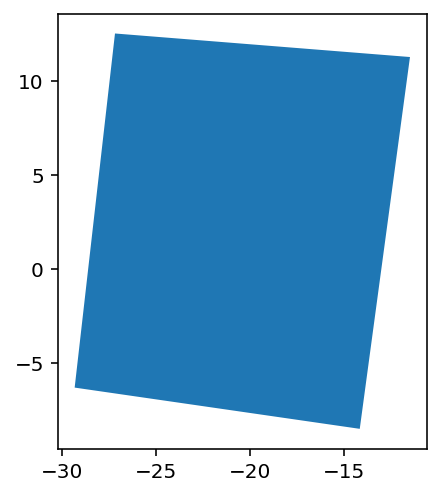

In [8]:
# Take a look at the shapefile in rotated pole projection
aoi_shp_rp.plot()

# Store the boundary of the shapefile
bounds = aoi_shp_rp.bounds
print(aoi_shp_rp.bounds)

In [9]:
minx = aoi_shp_rp.bounds.iloc[0]['minx']
maxx = aoi_shp_rp.bounds.iloc[0]['maxx']
miny = aoi_shp_rp.bounds.iloc[0]['miny']
maxy = aoi_shp_rp.bounds.iloc[0]['maxy']

### Slice snowmelt to shapefile boundary

In [10]:
aoi_melt = snowmelt.sel(rlon=slice(minx,maxx),rlat=slice(miny,maxy))
aoi_melt

<xarray.DataArray 'snowmelt' (time: 3165, rlat: 85, rlon: 71)>
[19100775 values with dtype=float32]
Coordinates:
    lon      (rlat, rlon) float64 -97.01 -97.13 -97.26 ... -33.74 -33.16 -32.57
    lat      (rlat, rlon) float64 -59.65 -59.88 -60.12 ... -72.57 -72.74 -72.91
  * rlon     (rlon) float64 -29.25 -29.0 -28.75 -28.5 ... -12.25 -12.0 -11.75
  * rlat     (rlat) float64 -8.5 -8.25 -8.0 -7.75 -7.5 ... 11.75 12.0 12.25 12.5
    height   float64 0.0
  * time     (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2019-08-31
Attributes:
    standard_name:  snowmelt
    long_name:      Snow Melt Flux
    units:          kg m-2 s-1
    cell_methods:   time: 24-hr averaged values
    grid_mapping:   rotated_pole

## Plot the AOI on RACMO Grid


### Select a date as ```data``` so it is easier to work with/plot, in this case 2014-01-01

In [11]:
data = aoi_melt.sel(time='2014-01-01')
data

<xarray.DataArray 'snowmelt' (rlat: 85, rlon: 71)>
array([[-2.885277e-08, -2.885277e-08, -2.885277e-08, ..., -2.885277e-08,
        -2.885277e-08, -2.885277e-08],
       [-2.885277e-08, -2.885277e-08, -2.885277e-08, ..., -2.885277e-08,
        -2.885277e-08, -2.885277e-08],
       [-2.885277e-08, -2.885277e-08, -2.885277e-08, ..., -2.885277e-08,
        -2.885277e-08, -2.885277e-08],
       ...,
       [-2.885277e-08, -2.885277e-08, -2.885277e-08, ..., -2.885277e-08,
        -2.885277e-08, -2.885277e-08],
       [-2.885277e-08, -2.885277e-08, -2.885277e-08, ..., -2.885277e-08,
        -2.885277e-08, -2.885277e-08],
       [-2.885277e-08, -2.885277e-08, -2.885277e-08, ..., -2.885277e-08,
        -2.885277e-08, -2.885277e-08]], dtype=float32)
Coordinates:
    lon      (rlat, rlon) float64 -97.01 -97.13 -97.26 ... -33.74 -33.16 -32.57
    lat      (rlat, rlon) float64 -59.65 -59.88 -60.12 ... -72.57 -72.74 -72.91
  * rlon     (rlon) float64 -29.25 -29.0 -28.75 -28.5 ... -12.25 -12.0 -11.75
  * rlat     (rlat) float64 -8.5 -8.25 -8.0 -7.75 -7.5 ... 11.75 12.0 12.25 12.5
    height   float64 0.0
    time     datetime64[ns] 2014-01-01
Attributes:
    standard_name:  snowmelt
    long_name:      Snow Melt Flux
    units:          kg m-2 s-1
    cell_methods:   time: 24-hr averaged values
    grid_mapping:   rotated_pole

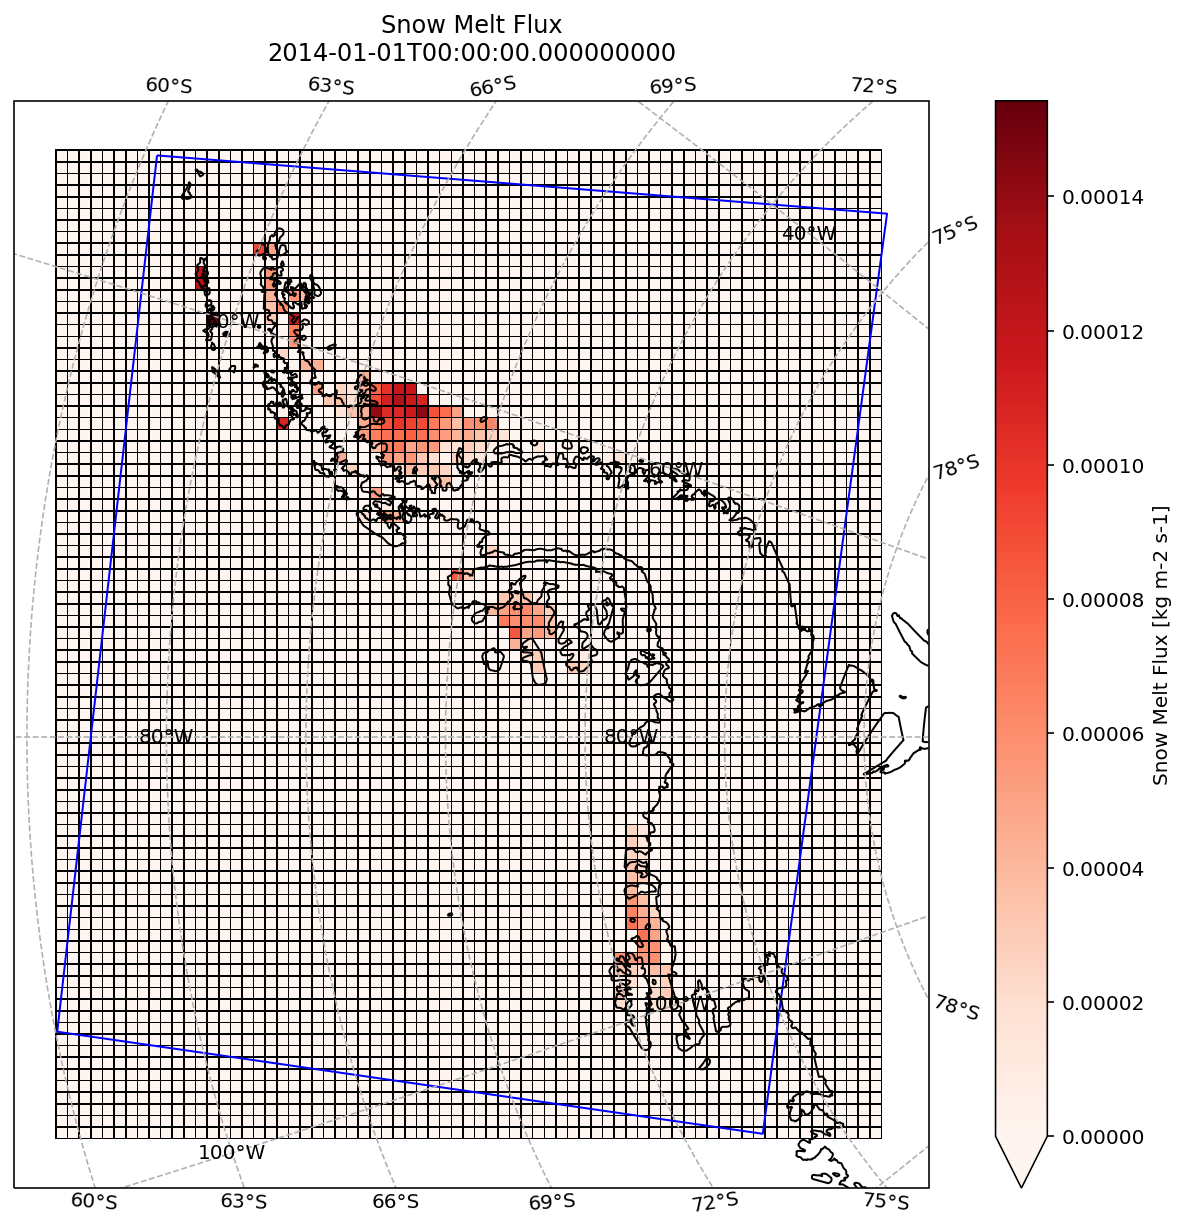

In [12]:
plt.figure(figsize=(12,10))
# plot data in rotated pole projection
ax = plt.subplot(projection=rp)
data.plot(ax=ax,transform=rp, cmap='Reds', vmin=0, edgecolor='k', linewidth=0.3)
ax.set_title(data.long_name+'\n'+str(data.time.values))
ax.coastlines(resolution='10m')
ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, linestyle='--')
aoi_shp_rp.plot(ax=ax, facecolor='none', edgecolor='b')
plt.show()

# Calculate cell area

### I used CDO (Climate Data Operators) https://code.mpimet.mpg.de/projects/cdo/ to calculate RACMO grid cell area 
```cdo gridarea infile outfile```<br>
```cdo gridarea RACMO2.3p2_ANT27_snowmelt_daily_2011_2019_08.nc gridarea.nc```<br>
The unit is in m2

In [13]:
area =xr.open_dataset(data_path/'gridarea.nc')
area

<xarray.Dataset>
Dimensions:    (rlat: 240, rlon: 262)
Coordinates:
  * rlon       (rlon) float64 -32.75 -32.5 -32.25 -32.0 ... 32.0 32.25 32.5
  * rlat       (rlat) float64 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75
Data variables:
    cell_area  (rlat, rlon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Aug 01 17:18:27 2020: cdo gridarea RACMO2.3p2_ANT27_sno...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

### Query all the grid cell area at AOI

In [14]:
aoi_area = area.sel(rlon=slice(minx,maxx),rlat=slice(miny,maxy))
aoi_area_value = aoi_area['cell_area'].values
aoi_area_value

array([[7.64281803e+08, 7.64281803e+08, 7.64281803e+08, ...,
        7.64281803e+08, 7.64281803e+08, 7.64281803e+08],
       [7.64772921e+08, 7.64772921e+08, 7.64772921e+08, ...,
        7.64772921e+08, 7.64772921e+08, 7.64772921e+08],
       [7.65249479e+08, 7.65249479e+08, 7.65249479e+08, ...,
        7.65249479e+08, 7.65249479e+08, 7.65249479e+08],
       ...,
       [7.55883059e+08, 7.55883059e+08, 7.55883059e+08, ...,
        7.55883059e+08, 7.55883059e+08, 7.55883059e+08],
       [7.55174813e+08, 7.55174813e+08, 7.55174813e+08, ...,
        7.55174813e+08, 7.55174813e+08, 7.55174813e+08],
       [7.54452190e+08, 7.54452190e+08, 7.54452190e+08, ...,
        7.54452190e+08, 7.54452190e+08, 7.54452190e+08]])

```areacella.KNMI.ANT3K27_fx_LDT.nc``` cell areas are in square km

In [15]:
trusel_grid_area = xr.open_dataset(data_path/'areacella.KNMI.ANT3K27_fx_LDT.nc')
aoi_area_trusel = trusel_grid_area.sel(rlon=slice(minx,maxx),rlat=slice(miny,maxy))
aoi_area_trusel['areacella'].values

array([[764.33405, 764.33405, 764.33405, ..., 764.33405, 764.33405,
        764.33405],
       [764.82526, 764.82526, 764.82526, ..., 764.82526, 764.82526,
        764.82526],
       [765.3018 , 765.3018 , 765.3018 , ..., 765.3018 , 765.3018 ,
        765.3018 ],
       ...,
       [755.9349 , 755.9349 , 755.9349 , ..., 755.9349 , 755.9349 ,
        755.9349 ],
       [755.22656, 755.22656, 755.22656, ..., 755.22656, 755.22656,
        755.22656],
       [754.5039 , 754.5039 , 754.5039 , ..., 754.5039 , 754.5039 ,
        754.5039 ]], dtype=float32)

kg m-2 s-1 is the unit of RACMO Snowmelt

# Calculate volume
## The cell area of AOI is 7.63776134e+08 square meter or 763.82843018 square kilometer
60X60X24=86400 seconds in 1 day<br>

1 kg/m2/s = 86400 mm/day.<br>

Volume = snowmelt in mm/s * 86400s /1000mm * grid cell area<br>
Volume = aoi cell's snowmelt (kg/m2/s) * 86400 s / 1000 * aoi's grid cell area (m2)  <br>

In [16]:
print(aoi_melt.shape)
print(aoi_area_value.shape)

(3165, 85, 71)
(85, 71)


In [17]:
aoi_volume = aoi_melt * 86400 / 1000 * aoi_area_value
aoi_volume

<xarray.DataArray 'snowmelt' (time: 3165, rlat: 85, rlon: 71)>
array([[[-1529.73168752, -1529.73168752, -1529.73168752, ...,
         -1529.73168752, -1529.73168752, -1529.73168752],
        [-1530.71467421, -1530.71467421, -1530.71467421, ...,
         -1530.71467421, -1530.71467421, -1530.71467421],
        [-1531.66851805, -1531.66851805, -1531.66851805, ...,
         -1531.66851805, -1531.66851805, -1531.66851805],
        ...,
        [-1512.92136262, -1512.92136262, -1512.92136262, ...,
         -1512.92136262, -1512.92136262, -1512.92136262],
        [-1511.50378886, -1511.50378886, -1511.50378886, ...,
         -1511.50378886, -1511.50378886, -1511.50378886],
        [-1510.05743802, -1510.05743802, -1510.05743802, ...,
         -1510.05743802, -1510.05743802, -1510.05743802]],

       [[    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        ...,
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ]],

       [[    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        ...,
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ]],

       ...,

       [[    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        ...,
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ]],

       [[    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        ...,
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ]],

       [[    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [    0.        ,     0.        ,     0.        , ...,
             0.        ,     0.        ,     0.        ],
        [

### ```aoi_volume``` is a multi-dimensional dataarray consists of grid cells over the AOI at multiple times
#### Let's apply the mean aggregation method over the time dimension and plot the result.

####  We can plot any time frame's mean snowmelt using ```slice```
For example, 2018 meltseason mean

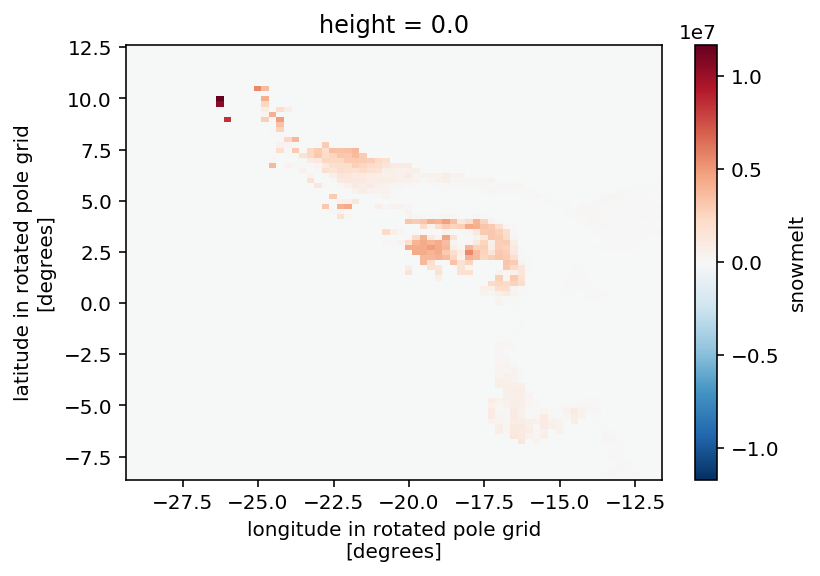

In [18]:
aoi_volume.sel(time=slice('2017-12-01','2018-03-01')).mean(dim='time').plot()

##### To aggregate all the grid cells at a time frame use ```.sel(time=slice('xxxx-xx-xx','xxxx-xx-xx'))``` and ```sum(dim=('rlon','rlat'))```

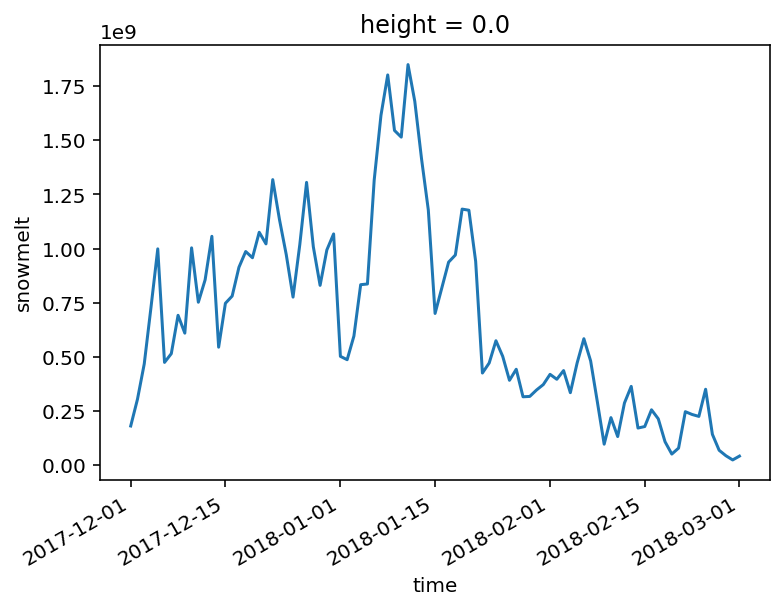

In [19]:
aoi_volume.sel(time=slice('2017-12-01','2018-03-01')).sum(dim=('rlon','rlat')).plot()

### Daily sum of all cells

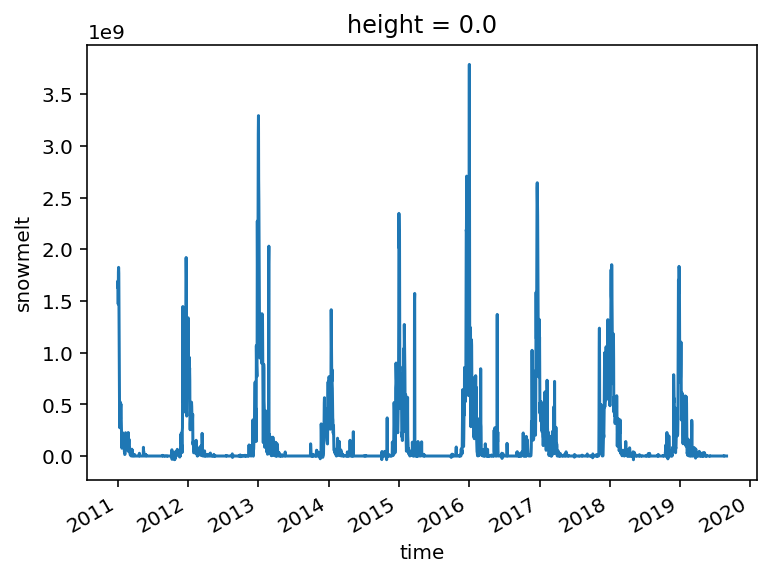

In [20]:
aoi_volume.sum(dim=('rlon','rlat')).plot()
#aoi_volume.mean(dim=('rlon','rlat')).to_dataframe()

### Calculate annual melt of all cells using ```groupby```

,height,snowmelt
year,,
2011,0.0,1.430779e+08
2012,0.0,1.168661e+08
2013,0.0,1.630635e+08
2014,0.0,8.280133e+07
2015,0.0,1.892286e+08
2016,0.0,2.075899e+08
2017,0.0,1.486878e+08
2018,0.0,1.609158e+08
2019,0.0,7.784026e+07


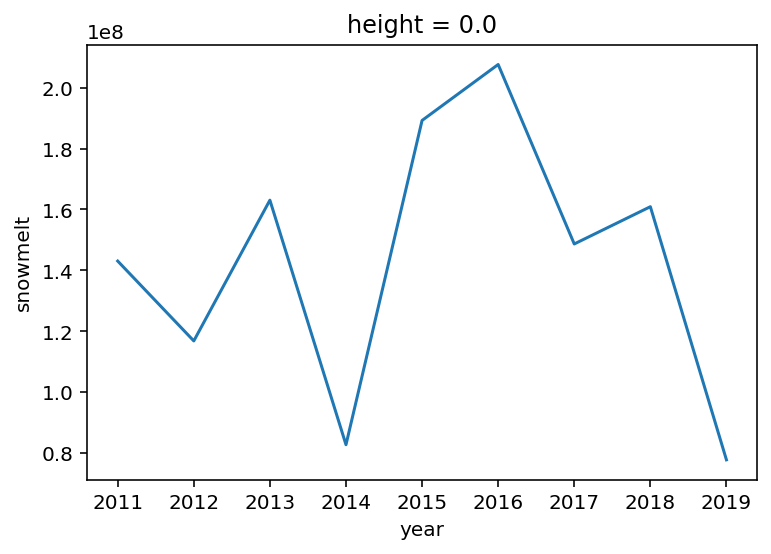

In [37]:
aoi_volume.sum(dim=('rlon','rlat')).groupby('time.year', restore_coord_dims=False).mean('time').plot()
aoi_volume.sum(dim=('rlon','rlat')).groupby('time.year', restore_coord_dims=False).mean('time').to_dataframe()

### Daily Mean of all cells

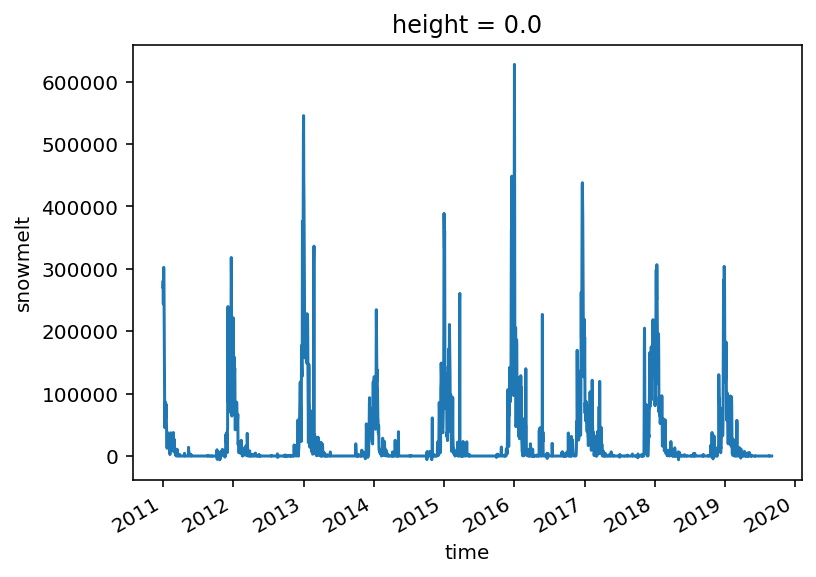

In [21]:
aoi_volume.mean(dim=('rlon','rlat')).plot()
#aoi_volume.mean(dim=('rlon','rlat')).to_dataframe()

### Select DJF and aggregate all cells
#### Then export to dataframe

In [22]:
djf_melt = aoi_volume.sel(time=ds.time.dt.season =='DJF').sum(dim=('rlon','rlat'))

In [23]:
df = djf_melt.to_dataframe().drop('height',1)
# drop all the zeros
df = df[(df!= 0).all('columns')]
df
# df.to_csv(output_path/'RACMO_snowmelt_19', header = True)

,snowmelt
time,
2011-01-01,1.634310e+09
2011-01-02,1.694954e+09
2011-01-03,1.469051e+09
2011-01-04,1.780280e+09
2011-01-05,1.824673e+09
...,...
2019-02-23,2.193831e+06
2019-02-24,2.389468e+07
2019-02-25,3.349803e+06


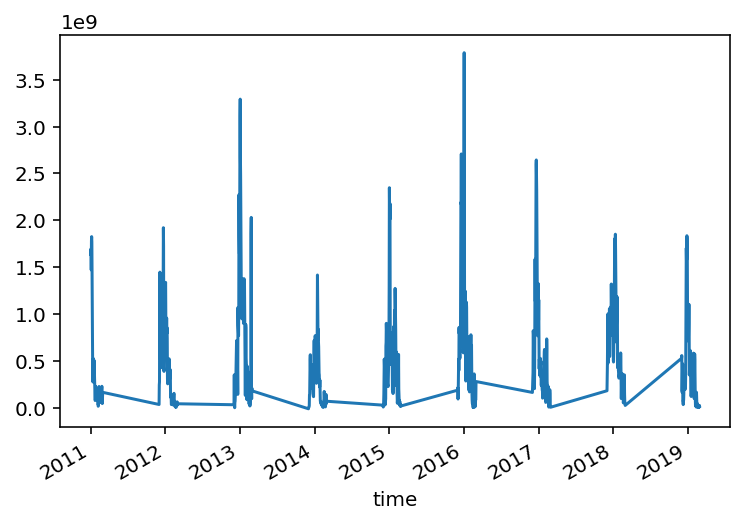

In [24]:
df['snowmelt'].plot()